# Gaussian Process for Design of Experiments

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.linalg import solve_triangular
from scipy.spatial import distance
from scipy.optimize import minimize
from mpl_toolkits.mplot3d import Axes3D

plt.style.use(['bmh'])
# print (plt.style.available)

Creating sample points from 0 to 1

In [2]:
n_sample = 30 # Numbre of sample points
n1 = n2 = np.linspace(0,1,n_sample).reshape(-1,1)

X1, X2 = np.meshgrid(n1,n2)

Function for case with 2 dimensions

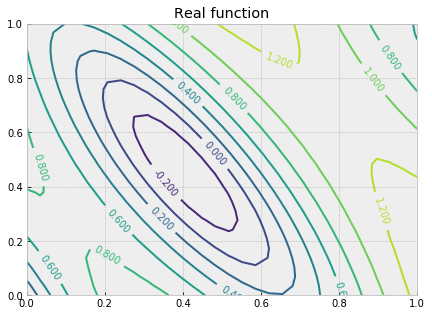

In [3]:
# Function case 1
def f_c1(x_1, x_2, t=np.pi/6):
    xr = np.cos(t)*x_1 + np.sin(t)*x_2
    xs = -np.sin(t)*x_1 + np.cos(t)*x_2
    return np.log(np.sin(2.5*np.pi*xr) + 1.5*x_1 + 2*xs**2 + 1)

fig = plt.figure(figsize=(7,5))
cs = plt.contour(X1, X2, f_c1(X1, X2), 10)
plt.clabel(cs, inline=1, fontsize=10)
plt.title('Real function')
plt.show()

Visual representation of real function

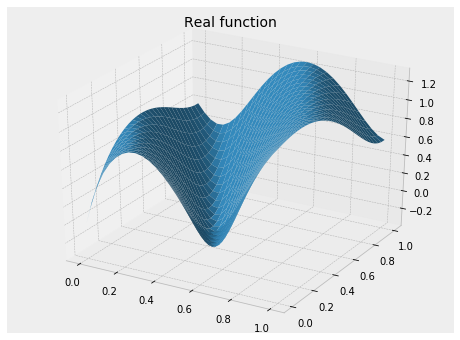

In [4]:
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection='3d')
ax.plot_surface(X1, X2, f_c1(X1, X2))
# ax.view_init(30,45)
plt.title('Real function', fontsize=14)
plt.show()

RBF kernel function definition

In [5]:
# RBF Kernel
def kernel(x, y, lengthscale, var):
    # Euclidean distance between x and y
    dif = distance.cdist(x,y, 'euclidean')**2
    return np.exp(-dif / (2*(lengthscale**2))) * var

In [6]:
#  Set of training points
Xc1 = np.array([[0.98529786, 0.55933787],
               [0.47589864, 0.37738477],
               [0.02279748, 0.03577601],
               [0.77232670, 0.96603697],
               [0.24643272, 0.78927301]])

In [7]:
# Computation of the function using the training points
Yc1 = f_c1(Xc1[:,0], Xc1[:,1]).reshape(-1,1)
Yc1

array([[ 1.09212698e+00],
       [-3.15166949e-01],
       [ 2.82343279e-01],
       [ 1.07614532e+00],
       [-4.47456350e-04]])

Searching for the best hyperparameters for the covariance function

In [8]:
def hyperParamSearch(x,                         # observed x data.
                     f,                         # observed y data.
                     n_parms=3,                 # No. parameters to be optimized.
                     bnds=(.000001, 3),   # Bounds where parameters can oscilate.
                     veb=False):                # print best final result.
    
    # The following functions defines the
    # GP's marginal likehood that It's used
    # to determine the bebst hyperparameters
    # for the covariance function. In this case
    # lenghtscale, variance and noise due to 
    # gaussian kernel.
    #
    # arguments:
    # parms => array (1, N) where N is the number
    #          of all hyperparameters.
    #
    # gp_loss needs to miminize it.
    
    def gp_loss(parms):      

        # compute kernel.
        K = kernel(x, x, parms[0], parms[1])

        # Cholesky decomposition of kernel with observations.
        L = np.linalg.cholesky(K + parms[2] * np.eye(len(K)))

        # alpha.
        alpha = solve_triangular(L.T, solve_triangular(L, f, lower=True))

        # Loss fuction.
        L = -0.5*f.T.dot(alpha) - np.sum(np.log(np.trace(L))) - 0.5*len(L)*np.log(2*np.pi)

        return -L
    
    # Initializing arrays to hold best gp loss
    # value and the set of hyperparameters.
    bst_loss = float('inf')
    bst_parms = np.empty((1, n_parms))
    
    # Function to be called by the optimizer
    # to maximize the function.
    def max_loss(x):
        return gp_loss(x)
    
    # Trunked search space for Hyperparms 
    # go from -> ((.000000001, maxFloat))
    bnds = [bnds] * n_parms
    
    # Initialization of random x0 values to avoid local
    # minima. For each x0 value the best minimun is taken.
    print ('Kernel hyperparameter search (wait..)')
    for x0 in np.random.uniform(1e-5, 1e1, size=(n_parms*20, n_parms)):

        res = minimize(max_loss, 
                       x0=x0, 
                       bounds=bnds,
                       method='L-BFGS-B')
        
        if res.fun < bst_loss:
            bst_loss = res.fun
            bst_parms = res.x  
    
    # Print best values.
    print ('...done!')
    if veb:
        print ('\nBest values')
        print ('-----------')
        print ('Loss: {}'.format(-bst_loss))
        print ('Params: {}\n'.format(bst_parms))
        
    return bst_parms

In [9]:
# Determine best hyperparameters values of
# conditional GP with training or observed values.
best_params = hyperParamSearch(Xc1, 
                               Yc1, 
                               veb=True)

Kernel hyperparameter search (wait..)
...done!

Best values
-----------
Loss: [[-7.07825395]]
Params: [3.33523758e-01 2.33704550e+00 1.00000000e-06]



GP inference

In [10]:
def gp_inference(x,            # observed x data (x1, x2, .. , xn) -> (n x k).
                 y,            # observed f data (y -> (n x 1)).
                 xpred,        # x data for predictions.
                 params):      # covariance hyperparameters.
    
    
    # The following variables are essencial
    # by either the mean or variance
    
    # Similarity between train points or observations.
    K = kernel(x, x, params[0], params[1])

    # Cholesky decomposition of kernel with observations.
    L = np.linalg.cholesky(K + params[2]*np.eye(len(K)))
    
    # Similarity between prediction and training data.
    K_pred_train = kernel(x, xpred, params[0], params[1])
                  
    # alpha.
    alpha = solve_triangular(L.T, solve_triangular(L, y, lower=True))

    # mean values.
    E_f = np.matmul(K_pred_train.T, alpha).flatten()
    
    # variance values.
    K_pred = kernel(xpred, xpred, params[0], params[1])
    v = solve_triangular(L, K_pred_train, lower=True)
    var_f = K_pred - np.dot(v.T, v)
                  
    return E_f, var_f

In [11]:
# Create test points.
Xpred = np.hstack((X1.reshape(-1,1), X2.reshape(-1,1)))
print('Test point shape: {}'.format(Xpred.shape))

Test point shape: (900, 2)


In [12]:
# Tet Infer (Posterior) with Gaussian Processes.
mu, var = gp_inference(Xc1, 
                       Yc1, 
                       Xpred, 
                       best_params)

Visualization of the uncertainty of the test points

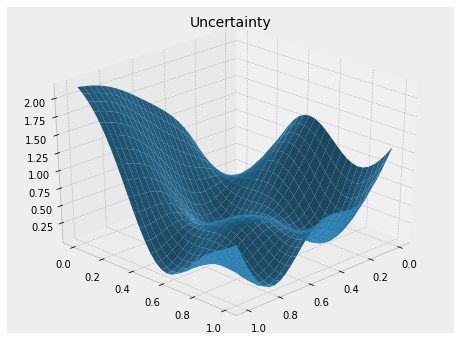

In [13]:
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection='3d')
ax.plot_surface(X1, X2, np.diag(var).reshape(X1.shape))
ax.view_init(30,45)
plt.title('Uncertainty', fontsize=14)
plt.show()

Reducing the uncertainty. Using the MMSE to find the points with maximum uncertainty, infere their value and introduce them as new training points

In [14]:
def propose_next_point(xtrain,         # observed x values (train data)
                       ytrain,
                       params,         # kernel hyperparameters.
                       alpha, 
                       bnds=(-1,1),    # bounds for inner seach optimization.
                       rt=30):         # restars values to avoid local min.
    
    # data dimension.
    dim = xtrain.shape[1]
    
    def mmse(x):
        
        # Get the variance of the training
        # point (xnew) in order to find the 
        # one which maximize the uncertainty.
        #
        # x = xnew (value to be optimized with
        #           inner optimizer)
        
        _, var_xnew = gp_inference(xtrain,                  # xtrain value augmented xnew
                                   ytrain,
                                   np.expand_dims(x, axis=0),  # pred. set
                                   params)
        
        return var_xnew
        
    # Function to compute the next observed
    # point which minimize the mmse
    bst_glbl = float('inf')
    bst_pt = np.empty((1, dim))

    def max_obj(x):
        return -mmse(x)
    
    # Find the best optimum with multiple re-starts.
    # 0 < x1 < 1 ; 0 < x2 < 1
    
    def min_func(x):
        return f_c1(x[0],x[1])
    
    def best_global(x):
        return (1-alpha)*max_obj(x) + alpha * min_func(x)
    
    for x0 in np.random.uniform(bnds[0], bnds[-1], size=(rt, dim)):
        
        res = minimize(best_global,
                        x0=x0,
                        bounds=[bnds]*dim,
                        method='L-BFGS-B')
        
        if res.fun < bst_glbl:
            bst_glbl = res.fun
            bst_pt = res.x
    
    return bst_pt, bst_glbl

Parameters for the DoE

In [15]:
# Initial conditions.
'''
iter      => DoE no. iteration.
target:   => Target value of interest.
epsilon:  => epsilon.
restart:  => random restart pts in search fn.
'''

DOEparam = {                           
        'iter'  :30,      # Nmbs of iterations in DOE (Limited by computational costs).                             
        'rest'  :20,      # Nmbs of restarts for inner optimization to avoid local min.
        'bounds':(0,1),   # Design limit space to seach points.
           }

In [17]:
for i in range(DOEparam['iter']):

    # Find hyperparameters previous to fit GP.
    bParms = hyperParamSearch(Xc1, 
                              Yc1, 
                              veb=False)
    
    # Search for the next smartest point to be SAMPLED.
    x_next, best_pt = propose_next_point(Xc1, 
                                       Yc1,
                                       bParms,
                                       0.05,
                                       bnds=DOEparam['bounds'],
                                       rt=DOEparam['rest'])

    print('==> DOE No:{} - Best {:.6} \
               \nPoint added: [{:.4}, {:.4}]\n'.format(i+1, -best_pt[0][0], 
                                                            x_next[0], 
                                                            x_next[1]))

    # Eval new searched point in function.
    y_next = f_c1(x_next[0], x_next[1])

    # Add new point to training set.
    Xc1 = np.vstack((Xc1, x_next))
    Yc1 = np.vstack((Yc1, y_next))

print ('done...')

Kernel hyperparameter search (wait..)
...done!
==> DOE No:1 - Best 1.98473                
Point added: [1.0, 0.0]

Kernel hyperparameter search (wait..)
...done!
==> DOE No:2 - Best 0.705226                
Point added: [0.0, 1.0]

Kernel hyperparameter search (wait..)
...done!
==> DOE No:3 - Best 0.372616                
Point added: [0.0, 0.0]

Kernel hyperparameter search (wait..)
...done!
==> DOE No:4 - Best 0.567435                
Point added: [1.0, 1.0]

Kernel hyperparameter search (wait..)
...done!
==> DOE No:5 - Best 0.495126                
Point added: [0.0, 1.0]

Kernel hyperparameter search (wait..)
...done!
==> DOE No:6 - Best 1.85011                
Point added: [0.5281, 0.0]

Kernel hyperparameter search (wait..)
...done!
==> DOE No:7 - Best 0.420729                
Point added: [0.0, 0.0]

Kernel hyperparameter search (wait..)
...done!
==> DOE No:8 - Best 1.67931                
Point added: [0.0, 0.4811]

Kernel hyperparameter search (wait..)
...done!
==> DOE No:9 -

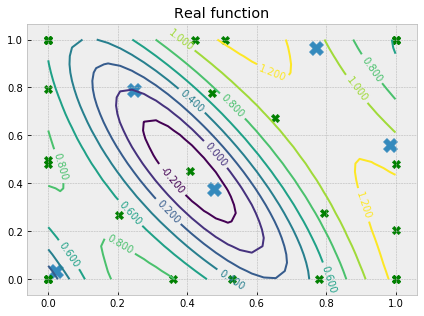

In [18]:
fig = plt.figure(figsize=(7,5))
cs = plt.contour(X1, X2, f_c1(X1, X2), 10)
plt.clabel(cs, inline=1, fontsize=10)
plt.scatter(Xc1[:5,0], Xc1[:5,1], marker='X', s=200)
plt.scatter(Xc1[5:,0], Xc1[5:,1], marker='X', c='g', s=70)
plt.title('Real function')
plt.show()

In [19]:
# Tet Infer (Posterior) with Gaussian Processes.
mu_new, var_new = gp_inference(Xc1, 
                       Yc1, 
                       Xpred, 
                       bParms)

Uncertainty after 30 iterations over the test data

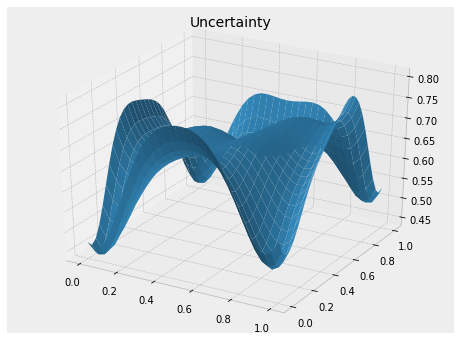

In [20]:
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection='3d')
ax.plot_surface(X1, X2, np.diag(var_new).reshape(X1.shape))
# ax.view_init(30,45)
plt.title('Uncertainty', fontsize=14)
plt.show()

Function prediction

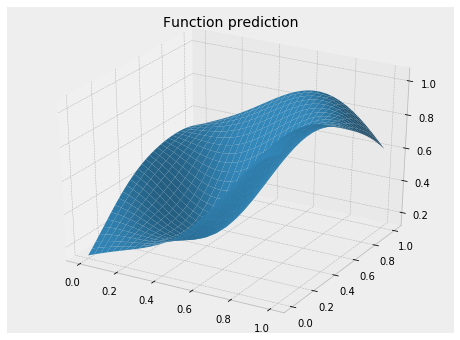

In [21]:
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection='3d')
ax.plot_surface(X1, X2, mu_new.reshape(X1.shape))
# ax.view_init(30,45)
plt.title('Function prediction', fontsize=14)
plt.show()

### Case with d=3

In [89]:
# Number of samples.
n_samples = 10

nx1 = nx2 = nx3 = np.linspace(0, 3, n_samples).reshape(-1,1)
X1, X2, X3 = np.meshgrid(nx1, nx2, nx3)

# real function.
def func_3d(x):
    '''
    The following function is used to compute
    the function value for training points
    '''
    
    c1, r1 = np.array([[.1],[.3],[.75]]), 0.02
    c2, r2 = np.array([[.15],[.8],[.5]]), 0.06
    c3, r3 = np.array([[.8],[.2],[.2]]),  0.02
    
    d1 = np.sum((x.T - c1)**2, axis=0) - r1
    d2 = np.sum((x.T - c2)**2, axis=0) - r2
    d3 = np.sum((x.T - c3)**2, axis=0) - r3
    
    s1 = np.sin(5*d1)+0.01*d1
    s2 = np.sin(4*d2)+0.01*d2
    s3 = np.sin(3*d3)+0.02*d3
    
    return s1+s2+s3

In [90]:
import pandas as pd

In [91]:
# Training data (dependent values).
Xc2 = pd.read_csv("/Users/danielha23/Desktop/GP_DoE/inputsCase2.csv", sep = ',').values
print ('Training observed values {}\n'.format(Xc2.shape))
Xc2[:5]

Training observed values (30, 3)



array([[ 0.06307849,  0.52767306,  0.23942085],
       [ 0.80421388,  0.02876601,  0.1697321 ],
       [ 0.75775574,  0.35830168,  0.09496949],
       [ 0.90550578,  0.65924051,  0.75630914],
       [ 0.73147696,  0.37883966,  0.54655965]])

In [92]:
Yc2 = func_3d(Xc2).reshape(-1,1)
Yc2[:5]

array([[ 2.30979765],
       [-1.82120284],
       [-0.36402599],
       [ 1.10577633],
       [ 2.22363853]])

In [93]:
# Determine best hyperparameters values of
# conditional GP with training or observed values.
best_params2 = hyperParamSearch(Xc2, 
                               Yc2, 
                               veb=True)

Kernel hyperparameter search (wait..)
...done!

Best values
-----------
Loss: [[-32.88190394]]
Params: [  0.48426714  57.83285695   3.33293903]



In [94]:
Xpred_3d = np.hstack((X1.reshape(-1,1), X2.reshape(-1,1), X3.reshape(-1,1)))
print('Test point shape: {}'.format(Xpred_3d.shape))

Test point shape: (1000, 3)


In [95]:
# Tet Infer (Posterior) with Gaussian Processes.
mu, var = gp_inference(Xc2, 
                       Yc2, 
                       Xpred_3d, 
                       best_params2)

In [96]:
for i in range(DOEparam['iter']):

    # Find hyperparameters previous to fit GP.
    bParms2 = hyperParamSearch(Xc2, 
                              Yc2, 
                              veb=False)
    
    # Search for the next smartest point to be SAMPLED.
    x_next, mmse = propose_next_point(Xc2, 
                                       Yc2,
                                       bParms2, 
                                       bnds=DOEparam['bounds'],
                                       rt=DOEparam['rest'])

    print('==> DOE No:{} - MMSE {:.6} \
               \nPoint added: [{:.4}, {:.4}]\n'.format(i+1, mmse[0][0], 
                                                            x_next[0], 
                                                            x_next[1],
                                                            x_next[2]))

    # Eval new searched point in function.
    y_next = func_3d(np.expand_dims(x_next, axis=0))

    # Add new point to training set.
    Xc2 = np.vstack((Xc2, x_next))
    Yc2 = np.vstack((Yc2, y_next))

print ('done...')

Kernel hyperparameter search (wait..)
...done!
==> DOE No:1 - MMSE 23.0196                
Point added: [1.0, 1.0]

Kernel hyperparameter search (wait..)
...done!
==> DOE No:2 - MMSE 20.2855                
Point added: [0.0, 0.0]

Kernel hyperparameter search (wait..)
...done!
==> DOE No:3 - MMSE 16.3785                
Point added: [0.0, 0.0]

Kernel hyperparameter search (wait..)
...done!
==> DOE No:4 - MMSE 17.8856                
Point added: [1.0, 1.0]

Kernel hyperparameter search (wait..)
...done!
==> DOE No:5 - MMSE 16.8787                
Point added: [1.0, 0.0]

Kernel hyperparameter search (wait..)
...done!
==> DOE No:6 - MMSE 15.9528                
Point added: [0.0, 1.0]

Kernel hyperparameter search (wait..)
...done!
==> DOE No:7 - MMSE 15.4905                
Point added: [0.0, 1.0]

Kernel hyperparameter search (wait..)
...done!
==> DOE No:8 - MMSE 15.7099                
Point added: [1.0, 0.0]

Kernel hyperparameter search (wait..)
...done!
==> DOE No:9 - MMSE 17.41

In [68]:
# Tet Infer (Posterior) with Gaussian Processes.
mu_new2, var_new2 = gp_inference(Xc2, 
                       Yc2, 
                       Xpred_3d, 
                       bParms2)